<a href="https://colab.research.google.com/github/neohack22/IASD/blob/IA/IA/projects/presentation/robustness/ROBUST_Notebook_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Moving to neural networks

Now that we've seen how adversarial examples work in the context of linear models, let's move to the setting we really care about: the possibility of adversarial examples in deep neural networks. 

First, let us define formally a neural network. Let us define $h_\theta(x) : \mathbb{R}^n \rightarrow \mathbb{R}^k$ to be an $d$-layer network, given by the following equations
\begin{equation}
\begin{split}
z_1 & = x \\
z_{i+1} & = f_i(W_i z_i + b_i), \;\; i,\ldots,d \\
h_\theta(x) & = z_{d+1}
\end{split}
\end{equation}
where $z_i$ denote the activations at layer $i$; $f_i$ denotes the activation function for layer $i$, which we will often take to be e.g. the ReLU operator $f_i(z) = \max\{0,z\}$ for layers $i=1,\ldots,d-1$ and the linear operator $f_i(z) = z$ for layer $d$ (remember, the last layer outputs are the class logits, and the loss function "builds in" the softmax operator, so we don't explicitly put the softmax into the network); and the parameters of the network are given by $\theta = \{W_1,b_1,\ldots,W_d,b_d\}$ (in the above, $W_i$ is most obviously interpreted a matrix, but it could really be any linear operator including convolutions).  We won't worry for now about explicitly defining the size of all the intermediate layers, but we assume that they are specified such that the final function $h_\theta$ takes inputs in $\mathbb{R}^n$ and outputs vectors in $\mathbb{R}^k$.  The loss function for multiclass case, namely the Cross Entropy loss, is as follows:
\begin{equation}
\ell(h_\theta(x), y) = \log \left ( \sum_{j=1}^k \exp(h_\theta(x)_j) \right ) - h_\theta(x)_y.
\end{equation}

## Crafting an attack

Unlike it the linear case, it is _not_ easy to solve, the maximization problem over our perturbation. This is because the cost surface for neural networks (here considering it over the _input_ space, not parameter space) is not convex, and is especially prone to local optima.  We can see this even in the simple example above, where there are local optimal when either trying to maximize or minimize the function above, and the initial gradient at a given point may or may not point in the direction of the actual maxima. 

So how _do_ we go about (approximately) solving the inner optimization problem
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y)
\end{equation}
in the case of $h_\theta$ being a neural network? 

The most common strategy to approximate the pertubation is to find a _lower bound_ on the optimization objective.  Because (by definition) _any_ feasible $\delta$ will give us a lower bound, this is equivalent to just "trying to empirically solve the optimization problem", i.e., "find an adversarial example."  
This is by far the most common strategy for solving the inner maximization motivated largely by the fact that for neural networks in general, problems of local optima don't seem as bad as initially may be thought. 

## Lower bounding the inner maximization (i.e., adversarial attacks)

Let's start by considering perhaps the simplest way of solving the optimization problem we care about, the task of maximizing
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}
In fact we already saw one example for how to do this in our introductory lecture, but the basic idea here is quite simple: using backpropagation, we can compute the gradient of the loss function with respect to the perturbation $\delta$ itself, so let's just perform gradient descent on $\delta$ to maximize our objective.  However, we also need to ensure that $\delta$ stays within the norm bound $\epsilon$, so after each step, we can project back into this space.



### The Fast Gradient Sign Method (FGSM)

Let's consider in a bit more detail how we might do the attack we mentioned above.  For some given example $x$, we know that we are going to adjust $\delta$ in the direction of it's gradient, i.e., we will first compute the gradient
\begin{equation}
g := \nabla_\delta \ell(h_\theta(x + \delta),y)
\end{equation}
using simple backpropagation; note that if we're evaluating this gradient at $\delta=0$ (as we would at the first timestep), then this is also just equal to $\nabla_x \ell(h_\theta(x),y)$, but we'll express the gradients in terms of $\delta$ to be consistent with how we do things going forward.

In order to maximize loss, we want to adjust delta in the direction of this gradient, i.e., take a step
\begin{equation}
\delta := \delta + \alpha g
\end{equation}
for some step size $\alpha$ and then project back into the norm ball defined by $\|\delta\| \leq \epsilon$.  But how big a step do we take?  For concreteness, let's consider the particular case of the $\ell_\infty$ norm $\|\delta\|_\infty \leq \epsilon$, where, as we mentioned before, projecting onto this norm ball simply involves clipping values of $\delta$ to lie within the range $[-\epsilon, \epsilon]$.  If our initial $\delta$ is zero, this gives the update
\begin{equation}
\delta := \mathrm{clip}(\alpha g, [-\epsilon, \epsilon]).
\end{equation}
Now, how big of a step size should we take?  If we want to make increase the loss as much as possible, it makes sense to take as large a step as possible, i.e., take $\alpha$ to be very large (of course knowing that we won't take _that_ big a step, since we're projecting back into the $\ell_\infty$ ball afterwards).  It is not hard to see that for $\alpha$ large enough, the relative sizes of the entries of $g$ won't matter: we will simply take $\delta_i$ to be either $+\epsilon$ or $-\epsilon$ depending upon the sign of $g_i$.  In other words, for large $\alpha$, this update becomes
\begin{equation}
\delta := \epsilon \cdot \mathrm{sign}(g).
\end{equation}

This is known as the Fast Gradient Sign Method (FGSM) [1], and it was one of the first methods for constructing adversarial examples proposed by the deep learning community.

[1] Explaining and Harnessing Adversarial Examples

### Exercice 2
1. Define a neural network with 3 fully connected layers
2. Define a neural network with 2 convolutional layers and a last fully connected layer
2. Train the network on the full MNIST Dataset
3. Code the FGSM attack
4. Evaluate your model against FGSM
5. Plot some images with and without the adversarial perturbation
6. Make an analysis of FGSM attack and compare it with the attack from the first notebook

In [1]:
import json
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

cuda = torch.cuda.is_available()

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline


classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
# load CIFAR10 dataset
def load_cifar(split, batch_size):
  train = True if split == 'train' else False
  dataset = datasets.CIFAR10(
      "./docs", train=split, download=True, transform=transforms.ToTensor())
  return DataLoader(dataset, batch_size=batch_size, shuffle=train)

batch_size = 100
train_loader = load_cifar('train', batch_size)
test_loader = load_cifar('test', batch_size)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./docs/cifar-10-python.tar.gz to ./docs
Files already downloaded and verified


#### Define a neural network with 3 fully connected layers

In [4]:
class FCModel(torch.nn.Module):

  def __init__(self):
    super(FCModel, self).__init__()

    self.fc1 = nn.Linear(16, 12)
    self.fc2 = nn.Linear(12, 10)
    self.fc3 = nn.Linear(10, 1)

  def forward(self, x):

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

fcmodel = FCModel()

fccriterion = torch.nn.CrossEntropyLoss()

#### Define a neural network with 2 convolutional layers and a last fully connected layer

In [5]:
class ConvModel(torch.nn.Module):
  
  def __init__(self):
    # convolutional model with
    super(ConvModel, self).__init__()
    # 2 convolution,
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
    self.relu = nn.ReLU()
    # 2 max pooling layer, 
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2,padding=0)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    # 3 fully connected layer
    self.lin1 = nn.Linear(64*64, 1000)
    self.lin2 = nn.Linear(1000, 120)
    self.lin3 = nn.Linear(120, 10)
    self.d_out = nn.Dropout(0.2)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)
    x = torch.flatten(x, 1) # flatten necessary dim

    
    x = self.lin1(x)
    x = self.relu(x)
    x=  self.d_out(x)

    x = self.lin2(x)
    x = self.relu(x)
    x=  self.d_out(x)
    
    x = self.lin3(x)
    x=  self.d_out(x)
    
    return x    

In [6]:
model = ConvModel()

In [7]:
print(model)
params = list(model.parameters())
print(len(params))
print(params[0].size())

ConvModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lin1): Linear(in_features=4096, out_features=1000, bias=True)
  (lin2): Linear(in_features=1000, out_features=120, bias=True)
  (lin3): Linear(in_features=120, out_features=10, bias=True)
  (d_out): Dropout(p=0.2, inplace=False)
)
10
torch.Size([32, 3, 3, 3])


#### Train the network on the full MNIST Dataset

In [8]:
def train_model(model, criterion, optimizer, loader):
  """Function to train the model"""
  epochs = 50 #epochs  = 10
  for epoch in range(epochs):
    for batch_n, (imgs, labels) in enumerate(loader):
      if cuda:
        imgs, labels = imgs.cuda(), labels.cuda()
      opt.zero_grad()
      outputs = model(imgs)
      loss = criterion(outputs, labels)
      loss.backward()
      opt.step()
    print("epoch: ", epoch, "loss: ", loss)

In [9]:
model = ConvModel()

# cuda to work with GPU

if cuda:
  model = model.cuda()

# define your loss function
criterion = nn.CrossEntropyLoss()

# define your optimizer
opt = torch.optim.SGD(model.parameters(), lr=0.02)

train_model(model, criterion, opt, train_loader)

epoch:  0 loss:  tensor(2.1929, grad_fn=<NllLossBackward0>)
epoch:  1 loss:  tensor(2.0613, grad_fn=<NllLossBackward0>)
epoch:  2 loss:  tensor(1.9643, grad_fn=<NllLossBackward0>)
epoch:  3 loss:  tensor(1.6828, grad_fn=<NllLossBackward0>)
epoch:  4 loss:  tensor(1.7364, grad_fn=<NllLossBackward0>)
epoch:  5 loss:  tensor(1.6238, grad_fn=<NllLossBackward0>)
epoch:  6 loss:  tensor(1.4007, grad_fn=<NllLossBackward0>)
epoch:  7 loss:  tensor(1.4345, grad_fn=<NllLossBackward0>)
epoch:  8 loss:  tensor(1.7041, grad_fn=<NllLossBackward0>)
epoch:  9 loss:  tensor(1.4221, grad_fn=<NllLossBackward0>)
epoch:  10 loss:  tensor(1.4896, grad_fn=<NllLossBackward0>)
epoch:  11 loss:  tensor(1.3162, grad_fn=<NllLossBackward0>)
epoch:  12 loss:  tensor(1.2007, grad_fn=<NllLossBackward0>)
epoch:  13 loss:  tensor(1.5493, grad_fn=<NllLossBackward0>)
epoch:  14 loss:  tensor(1.4712, grad_fn=<NllLossBackward0>)
epoch:  15 loss:  tensor(1.4049, grad_fn=<NllLossBackward0>)
epoch:  16 loss:  tensor(1.0720, g

In [10]:
#from google.colab import drive
#drive.mount('/content/drive')


def eval_model(model, loader, attack=None):
  """Function to evaluate your model on a specific loader"""
  accuracy = 0.
  n_inputs = 0.
  for n_batch, (imgs, labels) in enumerate(loader):
      if cuda:
        imgs, labels = imgs.cuda(), labels.cuda()
      if attack==None:
        outputs = model(imgs)
      else:
        outputs = model(imgs + attack.compute(imgs, labels))
      predicted = outputs.argmax(axis=1)
      n_inputs += outputs.size(0)
      accuracy += (predicted == labels).sum()
  accuracy = accuracy/n_inputs
  print("Accuracy: ", accuracy)


eval_model(model, test_loader)

Accuracy:  tensor(0.8605)


#### Code the FGSM attack

In [11]:
def fgsm_attack(image, epsilon, data_grad):
    # get the -wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    
    return perturbed_image


#### Evaluate your model against FGSM

In [12]:
# Adapted from 
# https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

epsilon = .03
def eval_model_underattack(model, loader, epsilon):
  """Function to evaluate your model on a specific loader"""

  # Test the Model

  model.eval()
  correct = 0
  correct_under_attack = 0
  total = 0
  for images, labels in test_loader:
      if cuda :
        images, labels = images.cuda(), labels.cuda()
      
      # Set requires_grad attribute of tensor. Important for Attack
      images.requires_grad = True
      # Classify the initial image (with no perturbation yet)
      outputs = model(images)
      _, predicted_label = torch.max(outputs.data, 1)
      correct += (predicted_label == labels).sum().item()
      # Calculate the loss
      loss = criterion(outputs, labels)
      # Zero all existing gradients
      model.zero_grad()
      # Backward
      loss.backward()
      # Collect images gradients
      images_grad = images.grad.data
      # Call FGSM Attack
      perturbed_image = fgsm_attack(images, epsilon, images_grad)
      # Re-classify the perturbed image
      outputs = model(perturbed_image)
      _, attacked_label = torch.max(outputs.data, 1)
      correct_under_attack += (attacked_label == labels).sum().item()

      total += labels.size(0)
      
    
  print(correct)
  print(correct_under_attack)
  print(total)
  print('Accuracy of the model on the test images: %d %%' % (100 * correct / total))
  print('Accuracy of the model on the test images under attack: %d %%' % (100 * correct_under_attack / total))

eval_model_underattack(model, test_loader,epsilon)

49721
3123
50000
Accuracy of the model on the test images: 99 %
Accuracy of the model on the test images under attack: 6 %


#### Plot some images with and without the adversarial perturbation

In [13]:
def generate_attacked_image(model, loader, epsilon):
  """Function to generate an attacked image"""
  # model.eval() disables any drop-out or batch normalization layers in model
  model.eval()
  for images, labels in test_loader:
      if cuda :
        images, labels = images.cuda(), labels.cuda()
      # Set requires_grad attribute of tensor. Important for Attack
      images.requires_grad = True
      # Classify the initial image (with no perturbation yet)
      outputs = model(images)
      # Calculate the loss
      loss = criterion(outputs, labels)
      # Zero all existing gradients
      model.zero_grad()
      # Backward
      loss.backward()
      # Collect images gradients
      images_grad = images.grad.data
      # Call FGSM Attack
      perturbed_image = fgsm_attack(images, epsilon, images_grad)
      return perturbed_image

In [14]:
def plot_images(x, y, yp, M=5, N=5):
  x = x.cpu().detach().numpy()
  y = y.cpu().detach().numpy()
  f, ax = plt.subplots(
      M, N, sharex=True, sharey=True, figsize=(N*2, M*1.3*2))
  for i in range(M):
    for j in range(N):
      img = x[i*N+j].transpose(1, 2, 0)
      img = np.maximum(0, np.minimum(img, 1))
      ax[i][j].imshow(img)
      title = ax[i][j].set_title(
          "{}".format(classes[yp[i*N+j].max(dim=0)[1]]))
      plt.setp(
          title, color=(
              'g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
      ax[i][j].set_axis_off()
    plt.tight_layout()
  plt.show()

====== NORMAL IMAGES ======


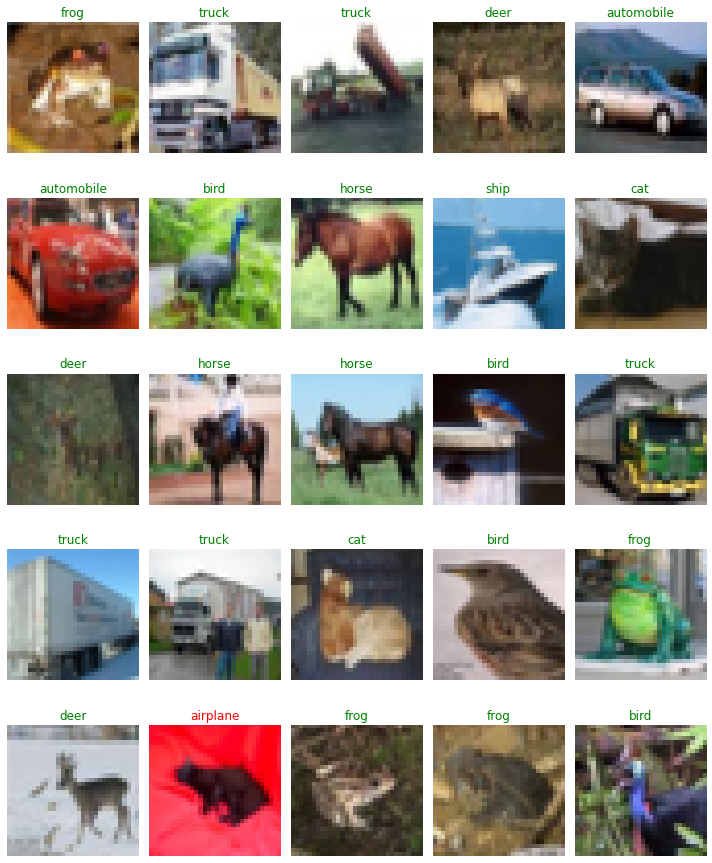

======= ATTACKED IMAGES =========


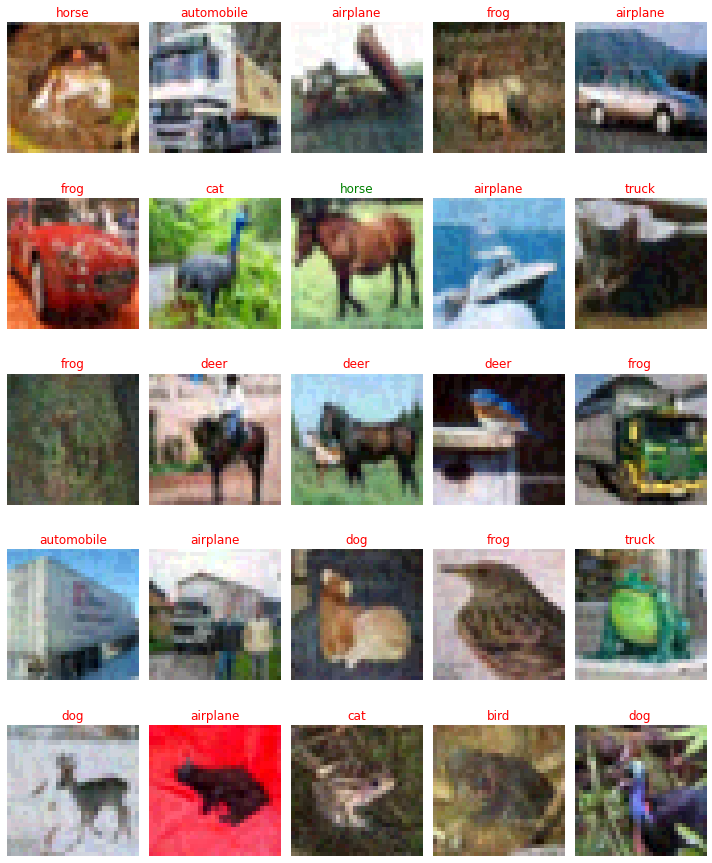

In [15]:
for imgs, labels in test_loader:
  if cuda:
    imgs, labels = imgs.cuda(), labels.cuda()
  break

# plot natural images
output = model(imgs)
print("=================================")
print("====== NORMAL IMAGES ======")
print("=================================")
plot_images(imgs, labels, output)
  
# plot adversarial images
epsilon = .03
attacked_images=generate_attacked_image(model, test_loader, epsilon)
output = model(attacked_images)
print("=================================")
print("======= ATTACKED IMAGES =========")
print("=================================")

plot_images(attacked_images, labels, output)

*   Green: good prediction
*   Red: wrong prediction

#### Make an analysis of FGSM attack and compare it with the attack from the first notebook

50000
50000
Feature batch shape: torch.Size([100, 3, 32, 32])
Labels batch shape: torch.Size([100])


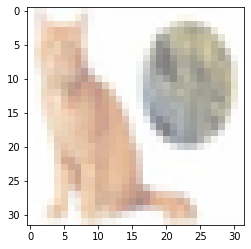

Label: cat


In [16]:
print(len(train_loader.dataset))
print(len(test_loader.dataset))


# Adapted from https://ibelieveai.github.io/cifar-classification-pytorch-1/#visualize-a-batch-of-training-data
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))

batch = next(train_loader.__iter__())
train_features, train_labels = batch
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# Adapted from https://ibelieveai.github.io/cifar-classification-pytorch-1/#loading-the-dataset
images = train_features.numpy() # convert images to numpy for display
img = images[0]
img = img / 2 + 0.5  # unnormalize
img = np.transpose(img, (1, 2, 0))
label = classes[train_labels[0]]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

Clip should limit the values in an array.<br>
Given an interval, values outside the interval would be clipped to the interval edges.<br>
For example, if an interval of [0, 1] is specified, values smaller than 0 become 0, and values larger than 1 become 1.<br>
But there's no need to add clipping in this example to maintain [0,1] range as the CIFAR10 data loaded come already between 0 and 1.

The model should be: 2x (conv -> max pooling -> relu) -> 2x (fc -> relu) -> fc.<br>
There's no need to apply the softmax here because it will be in the cross entropy loss too.

We set the model to evaluation mode with model.eval() to disable any drop-out or batch normalization layers in model.

With 3% epsilon, Accuracy reduced from 99% to 6% after attack!

### Projected gradient descent

This discussion immediately brings us to the next approach we would want to consider for maximizing the optimization problem, just doing projected gradient descent (i.e., the above procedure, but iterating it and with a smaller step size). [Note: technically speaking, this is gradient _ascent_ since we are maximizing a function rather than minimization, but it's common to just refer to the process as gradient descent.]. This was also called the "basic iterative procedure" in it's first appearance within the adversarial attacks literature [1], but essentially it is just the obvious choice for how we might maximize the inner objective a bit more carefully than with FGSM. The basic PGD algorithm simply iterates the updates:
\begin{equation}
\begin{split}
& \mbox{Repeat:} \\
& \quad \delta := \mathcal{P}(\delta + \alpha \nabla_\delta \ell(h_\theta(x+\delta), y))
\end{split}
\end{equation}
where $\mathcal{P}$ denotes the projection onto the ball of interest (for example, clipping in the case of the $\ell_\infty$ norm).  Of course, with PGD we now have more choices we need to make when specifying the attack, such as the actual stepsize itself, and the number of iterations (we'll discuss some rules of thumb shortly once we present a slightly modified version of the above iteration).  We can implement this attack in the following manner, where we're here going to implement the gradient descent procedure rather than rely on one of PyTorch's optimizers, as we want to see what's going on a bit more explicitly (PyTorch's SGD also includes terms like momentum, which actually usually are able to optimize the inner term _better_, but we want to have as little black-box procedures here as possible).

[1] Adversarial Machine Learning At Scale

In [17]:
class ProjectedGradientDescent:
  def __init__(self, model, eps, alpha, num_iter):
    
    self.model=model
    self.eps=eps
    self.alpha=alpha
    self.num_iter=num_iter
  
  def compute(self, X, y):
    """ Construct PGD adversarial pertubration on the examples x."""  
    """ Construct Projected Gradient Descent adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(self.num_iter):
        loss = nn.CrossEntropyLoss()(self.model(X + delta), y)
        loss.backward()
        
        delta.data = (
            delta + X.shape[
                0]*self.alpha*delta.grad.detach().sign()).clamp(
                -epsilon,epsilon)
        delta.grad.zero_()
    attacked_image= X + delta.detach()
    return attacked_image

pgd = ProjectedGradientDescent(model, 0.03, 0.0001, 100)

====== NORMAL IMAGES ======


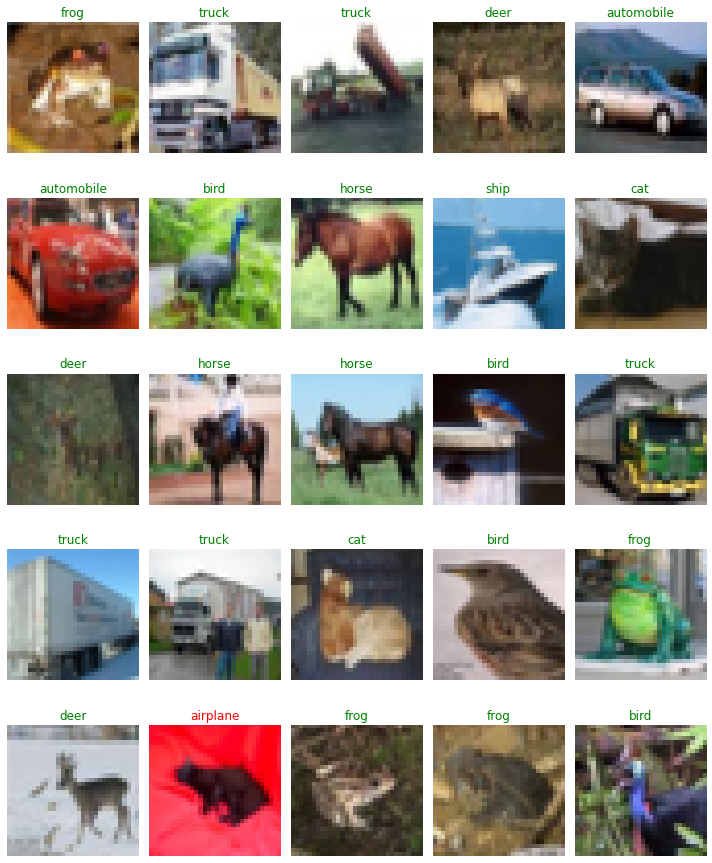

======= ATTACKED IMAGES =========


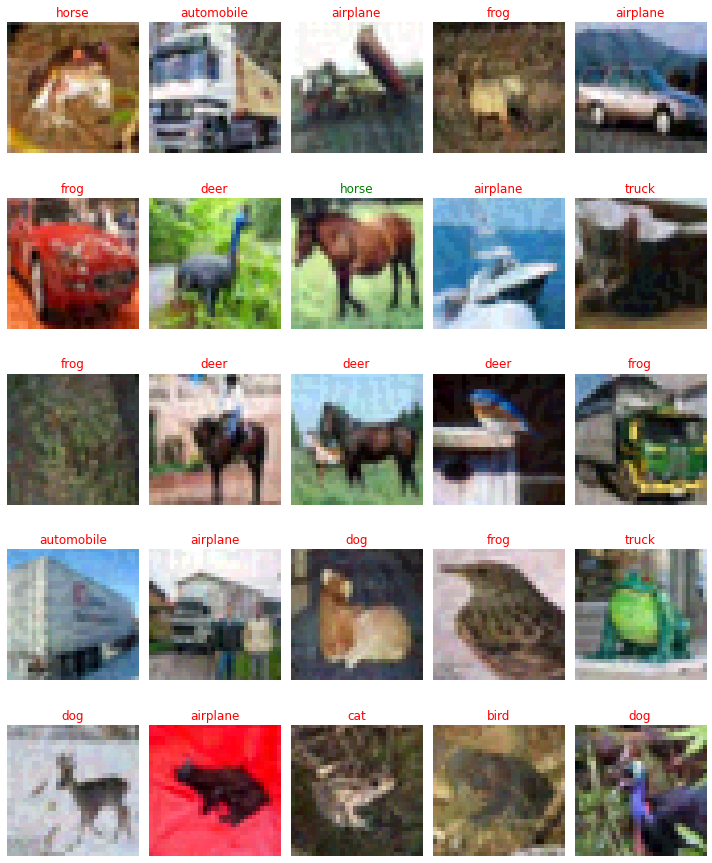

In [18]:
for imgs, labels in test_loader:
  if cuda:
    imgs, labels = imgs.cuda(), labels.cuda()
  break


# plot natural images
output = model(imgs)
print("=================================")
print("====== NORMAL IMAGES ======")
print("=================================")
plot_images(imgs, labels, output)
  
# plot adversarial images
epsilon = .03
attacked_images=pgd.compute(imgs,labels)
output = model(attacked_images)
print("=================================")
print("======= ATTACKED IMAGES =========")
print("=================================")

plot_images(attacked_images, labels, output)

Let's use the (pre-trained) ResNet50 model within PyTorch to classify a real picture of a pig.<br>
The normal strategy for image classification in PyTorch is to first transform the image (to approximately zero-mean, unit variance) using the `torchvision.transforms` module.<br>
However, because we'd like to make perturbations in the original (unnormalized) image space, we'll take a slightly different approach and actually build the transformations at PyTorch layers, so that we can directly feed the image in.<br>
First, let's just load the image and resize the 224x224, which is the default size that most ImageNet images (and hence the pre-trained classifiers) take as input.

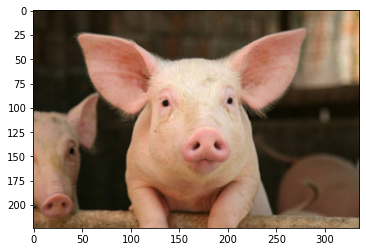

In [19]:
# read the image, resize to 224 and convert to PyTorch Tensor
pig_img = Image.open("/content/pig.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None,:,:,:]

# plot image
plt.imshow(
    pig_tensor[0].numpy().transpose(
# note that numpy uses HWC whereas Pytorch uses CHW, so we need to convert
        1,2,0))
plt.show()

In [20]:
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]


# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(
# values are standard normalization for ImageNet images    
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50
model = resnet50(pretrained=True)
# put into evaluation mode (necessary to e.g. turn off batchnorm)
model.eval();

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [21]:
# form predictions
pred = model(norm(pig_tensor))

Attack the pig image and plot the perturbation.

In [22]:
imagenet_classes = {0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma maculatum',
 29: 'axolotl, mud puppy, Ambystoma mexicanum',
 30: 'bullfrog, Rana catesbeiana',
 31: 'tree frog, tree-frog',
 32: 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui',
 33: 'loggerhead, loggerhead turtle, Caretta caretta',
 34: 'leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea',
 35: 'mud turtle',
 36: 'terrapin',
 37: 'box turtle, box tortoise',
 38: 'banded gecko',
 39: 'common iguana, iguana, Iguana iguana',
 40: 'American chameleon, anole, Anolis carolinensis',
 41: 'whiptail, whiptail lizard',
 42: 'agama',
 43: 'frilled lizard, Chlamydosaurus kingi',
 44: 'alligator lizard',
 45: 'Gila monster, Heloderma suspectum',
 46: 'green lizard, Lacerta viridis',
 47: 'African chameleon, Chamaeleo chamaeleon',
 48: 'Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis',
 49: 'African crocodile, Nile crocodile, Crocodylus niloticus',
 50: 'American alligator, Alligator mississipiensis',
 51: 'triceratops',
 52: 'thunder snake, worm snake, Carphophis amoenus',
 53: 'ringneck snake, ring-necked snake, ring snake',
 54: 'hognose snake, puff adder, sand viper',
 55: 'green snake, grass snake',
 56: 'king snake, kingsnake',
 57: 'garter snake, grass snake',
 58: 'water snake',
 59: 'vine snake',
 60: 'night snake, Hypsiglena torquata',
 61: 'boa constrictor, Constrictor constrictor',
 62: 'rock python, rock snake, Python sebae',
 63: 'Indian cobra, Naja naja',
 64: 'green mamba',
 65: 'sea snake',
 66: 'horned viper, cerastes, sand viper, horned asp, Cerastes cornutus',
 67: 'diamondback, diamondback rattlesnake, Crotalus adamanteus',
 68: 'sidewinder, horned rattlesnake, Crotalus cerastes',
 69: 'trilobite',
 70: 'harvestman, daddy longlegs, Phalangium opilio',
 71: 'scorpion',
 72: 'black and gold garden spider, Argiope aurantia',
 73: 'barn spider, Araneus cavaticus',
 74: 'garden spider, Aranea diademata',
 75: 'black widow, Latrodectus mactans',
 76: 'tarantula',
 77: 'wolf spider, hunting spider',
 78: 'tick',
 79: 'centipede',
 80: 'black grouse',
 81: 'ptarmigan',
 82: 'ruffed grouse, partridge, Bonasa umbellus',
 83: 'prairie chicken, prairie grouse, prairie fowl',
 84: 'peacock',
 85: 'quail',
 86: 'partridge',
 87: 'African grey, African gray, Psittacus erithacus',
 88: 'macaw',
 89: 'sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita',
 90: 'lorikeet',
 91: 'coucal',
 92: 'bee eater',
 93: 'hornbill',
 94: 'hummingbird',
 95: 'jacamar',
 96: 'toucan',
 97: 'drake',
 98: 'red-breasted merganser, Mergus serrator',
 99: 'goose',
 100: 'black swan, Cygnus atratus',
 101: 'tusker',
 102: 'echidna, spiny anteater, anteater',
 103: 'platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus',
 104: 'wallaby, brush kangaroo',
 105: 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus',
 106: 'wombat',
 107: 'jellyfish',
 108: 'sea anemone, anemone',
 109: 'brain coral',
 110: 'flatworm, platyhelminth',
 111: 'nematode, nematode worm, roundworm',
 112: 'conch',
 113: 'snail',
 114: 'slug',
 115: 'sea slug, nudibranch',
 116: 'chiton, coat-of-mail shell, sea cradle, polyplacophore',
 117: 'chambered nautilus, pearly nautilus, nautilus',
 118: 'Dungeness crab, Cancer magister',
 119: 'rock crab, Cancer irroratus',
 120: 'fiddler crab',
 121: 'king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica',
 122: 'American lobster, Northern lobster, Maine lobster, Homarus americanus',
 123: 'spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish',
 124: 'crayfish, crawfish, crawdad, crawdaddy',
 125: 'hermit crab',
 126: 'isopod',
 127: 'white stork, Ciconia ciconia',
 128: 'black stork, Ciconia nigra',
 129: 'spoonbill',
 130: 'flamingo',
 131: 'little blue heron, Egretta caerulea',
 132: 'American egret, great white heron, Egretta albus',
 133: 'bittern',
 134: 'crane',
 135: 'limpkin, Aramus pictus',
 136: 'European gallinule, Porphyrio porphyrio',
 137: 'American coot, marsh hen, mud hen, water hen, Fulica americana',
 138: 'bustard',
 139: 'ruddy turnstone, Arenaria interpres',
 140: 'red-backed sandpiper, dunlin, Erolia alpina',
 141: 'redshank, Tringa totanus',
 142: 'dowitcher',
 143: 'oystercatcher, oyster catcher',
 144: 'pelican',
 145: 'king penguin, Aptenodytes patagonica',
 146: 'albatross, mollymawk',
 147: 'grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus',
 148: 'killer whale, killer, orca, grampus, sea wolf, Orcinus orca',
 149: 'dugong, Dugong dugon',
 150: 'sea lion',
 151: 'Chihuahua',
 152: 'Japanese spaniel',
 153: 'Maltese dog, Maltese terrier, Maltese',
 154: 'Pekinese, Pekingese, Peke',
 155: 'Shih-Tzu',
 156: 'Blenheim spaniel',
 157: 'papillon',
 158: 'toy terrier',
 159: 'Rhodesian ridgeback',
 160: 'Afghan hound, Afghan',
 161: 'basset, basset hound',
 162: 'beagle',
 163: 'bloodhound, sleuthhound',
 164: 'bluetick',
 165: 'black-and-tan coonhound',
 166: 'Walker hound, Walker foxhound',
 167: 'English foxhound',
 168: 'redbone',
 169: 'borzoi, Russian wolfhound',
 170: 'Irish wolfhound',
 171: 'Italian greyhound',
 172: 'whippet',
 173: 'Ibizan hound, Ibizan Podenco',
 174: 'Norwegian elkhound, elkhound',
 175: 'otterhound, otter hound',
 176: 'Saluki, gazelle hound',
 177: 'Scottish deerhound, deerhound',
 178: 'Weimaraner',
 179: 'Staffordshire bullterrier, Staffordshire bull terrier',
 180: 'American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier',
 181: 'Bedlington terrier',
 182: 'Border terrier',
 183: 'Kerry blue terrier',
 184: 'Irish terrier',
 185: 'Norfolk terrier',
 186: 'Norwich terrier',
 187: 'Yorkshire terrier',
 188: 'wire-haired fox terrier',
 189: 'Lakeland terrier',
 190: 'Sealyham terrier, Sealyham',
 191: 'Airedale, Airedale terrier',
 192: 'cairn, cairn terrier',
 193: 'Australian terrier',
 194: 'Dandie Dinmont, Dandie Dinmont terrier',
 195: 'Boston bull, Boston terrier',
 196: 'miniature schnauzer',
 197: 'giant schnauzer',
 198: 'standard schnauzer',
 199: 'Scotch terrier, Scottish terrier, Scottie',
 200: 'Tibetan terrier, chrysanthemum dog',
 201: 'silky terrier, Sydney silky',
 202: 'soft-coated wheaten terrier',
 203: 'West Highland white terrier',
 204: 'Lhasa, Lhasa apso',
 205: 'flat-coated retriever',
 206: 'curly-coated retriever',
 207: 'golden retriever',
 208: 'Labrador retriever',
 209: 'Chesapeake Bay retriever',
 210: 'German short-haired pointer',
 211: 'vizsla, Hungarian pointer',
 212: 'English setter',
 213: 'Irish setter, red setter',
 214: 'Gordon setter',
 215: 'Brittany spaniel',
 216: 'clumber, clumber spaniel',
 217: 'English springer, English springer spaniel',
 218: 'Welsh springer spaniel',
 219: 'cocker spaniel, English cocker spaniel, cocker',
 220: 'Sussex spaniel',
 221: 'Irish water spaniel',
 222: 'kuvasz',
 223: 'schipperke',
 224: 'groenendael',
 225: 'malinois',
 226: 'briard',
 227: 'kelpie',
 228: 'komondor',
 229: 'Old English sheepdog, bobtail',
 230: 'Shetland sheepdog, Shetland sheep dog, Shetland',
 231: 'collie',
 232: 'Border collie',
 233: 'Bouvier des Flandres, Bouviers des Flandres',
 234: 'Rottweiler',
 235: 'German shepherd, German shepherd dog, German police dog, alsatian',
 236: 'Doberman, Doberman pinscher',
 237: 'miniature pinscher',
 238: 'Greater Swiss Mountain dog',
 239: 'Bernese mountain dog',
 240: 'Appenzeller',
 241: 'EntleBucher',
 242: 'boxer',
 243: 'bull mastiff',
 244: 'Tibetan mastiff',
 245: 'French bulldog',
 246: 'Great Dane',
 247: 'Saint Bernard, St Bernard',
 248: 'Eskimo dog, husky',
 249: 'malamute, malemute, Alaskan malamute',
 250: 'Siberian husky',
 251: 'dalmatian, coach dog, carriage dog',
 252: 'affenpinscher, monkey pinscher, monkey dog',
 253: 'basenji',
 254: 'pug, pug-dog',
 255: 'Leonberg',
 256: 'Newfoundland, Newfoundland dog',
 257: 'Great Pyrenees',
 258: 'Samoyed, Samoyede',
 259: 'Pomeranian',
 260: 'chow, chow chow',
 261: 'keeshond',
 262: 'Brabancon griffon',
 263: 'Pembroke, Pembroke Welsh corgi',
 264: 'Cardigan, Cardigan Welsh corgi',
 265: 'toy poodle',
 266: 'miniature poodle',
 267: 'standard poodle',
 268: 'Mexican hairless',
 269: 'timber wolf, grey wolf, gray wolf, Canis lupus',
 270: 'white wolf, Arctic wolf, Canis lupus tundrarum',
 271: 'red wolf, maned wolf, Canis rufus, Canis niger',
 272: 'coyote, prairie wolf, brush wolf, Canis latrans',
 273: 'dingo, warrigal, warragal, Canis dingo',
 274: 'dhole, Cuon alpinus',
 275: 'African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus',
 276: 'hyena, hyaena',
 277: 'red fox, Vulpes vulpes',
 278: 'kit fox, Vulpes macrotis',
 279: 'Arctic fox, white fox, Alopex lagopus',
 280: 'grey fox, gray fox, Urocyon cinereoargenteus',
 281: 'tabby, tabby cat',
 282: 'tiger cat',
 283: 'Persian cat',
 284: 'Siamese cat, Siamese',
 285: 'Egyptian cat',
 286: 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor',
 287: 'lynx, catamount',
 288: 'leopard, Panthera pardus',
 289: 'snow leopard, ounce, Panthera uncia',
 290: 'jaguar, panther, Panthera onca, Felis onca',
 291: 'lion, king of beasts, Panthera leo',
 292: 'tiger, Panthera tigris',
 293: 'cheetah, chetah, Acinonyx jubatus',
 294: 'brown bear, bruin, Ursus arctos',
 295: 'American black bear, black bear, Ursus americanus, Euarctos americanus',
 296: 'ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus',
 297: 'sloth bear, Melursus ursinus, Ursus ursinus',
 298: 'mongoose',
 299: 'meerkat, mierkat',
 300: 'tiger beetle',
 301: 'ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle',
 302: 'ground beetle, carabid beetle',
 303: 'long-horned beetle, longicorn, longicorn beetle',
 304: 'leaf beetle, chrysomelid',
 305: 'dung beetle',
 306: 'rhinoceros beetle',
 307: 'weevil',
 308: 'fly',
 309: 'bee',
 310: 'ant, emmet, pismire',
 311: 'grasshopper, hopper',
 312: 'cricket',
 313: 'walking stick, walkingstick, stick insect',
 314: 'cockroach, roach',
 315: 'mantis, mantid',
 316: 'cicada, cicala',
 317: 'leafhopper',
 318: 'lacewing, lacewing fly',
 319: "dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk",
 320: 'damselfly',
 321: 'admiral',
 322: 'ringlet, ringlet butterfly',
 323: 'monarch, monarch butterfly, milkweed butterfly, Danaus plexippus',
 324: 'cabbage butterfly',
 325: 'sulphur butterfly, sulfur butterfly',
 326: 'lycaenid, lycaenid butterfly',
 327: 'starfish, sea star',
 328: 'sea urchin',
 329: 'sea cucumber, holothurian',
 330: 'wood rabbit, cottontail, cottontail rabbit',
 331: 'hare',
 332: 'Angora, Angora rabbit',
 333: 'hamster',
 334: 'porcupine, hedgehog',
 335: 'fox squirrel, eastern fox squirrel, Sciurus niger',
 336: 'marmot',
 337: 'beaver',
 338: 'guinea pig, Cavia cobaya',
 339: 'sorrel',
 340: 'zebra',
 341: 'hog, pig, grunter, squealer, Sus scrofa',
 342: 'wild boar, boar, Sus scrofa',
 343: 'warthog',
 344: 'hippopotamus, hippo, river horse, Hippopotamus amphibius',
 345: 'ox',
 346: 'water buffalo, water ox, Asiatic buffalo, Bubalus bubalis',
 347: 'bison',
 348: 'ram, tup',
 349: 'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis',
 350: 'ibex, Capra ibex',
 351: 'hartebeest',
 352: 'impala, Aepyceros melampus',
 353: 'gazelle',
 354: 'Arabian camel, dromedary, Camelus dromedarius',
 355: 'llama',
 356: 'weasel',
 357: 'mink',
 358: 'polecat, fitch, foulmart, foumart, Mustela putorius',
 359: 'black-footed ferret, ferret, Mustela nigripes',
 360: 'otter',
 361: 'skunk, polecat, wood pussy',
 362: 'badger',
 363: 'armadillo',
 364: 'three-toed sloth, ai, Bradypus tridactylus',
 365: 'orangutan, orang, orangutang, Pongo pygmaeus',
 366: 'gorilla, Gorilla gorilla',
 367: 'chimpanzee, chimp, Pan troglodytes',
 368: 'gibbon, Hylobates lar',
 369: 'siamang, Hylobates syndactylus, Symphalangus syndactylus',
 370: 'guenon, guenon monkey',
 371: 'patas, hussar monkey, Erythrocebus patas',
 372: 'baboon',
 373: 'macaque',
 374: 'langur',
 375: 'colobus, colobus monkey',
 376: 'proboscis monkey, Nasalis larvatus',
 377: 'marmoset',
 378: 'capuchin, ringtail, Cebus capucinus',
 379: 'howler monkey, howler',
 380: 'titi, titi monkey',
 381: 'spider monkey, Ateles geoffroyi',
 382: 'squirrel monkey, Saimiri sciureus',
 383: 'Madagascar cat, ring-tailed lemur, Lemur catta',
 384: 'indri, indris, Indri indri, Indri brevicaudatus',
 385: 'Indian elephant, Elephas maximus',
 386: 'African elephant, Loxodonta africana',
 387: 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens',
 388: 'giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca',
 389: 'barracouta, snoek',
 390: 'eel',
 391: 'coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch',
 392: 'rock beauty, Holocanthus tricolor',
 393: 'anemone fish',
 394: 'sturgeon',
 395: 'gar, garfish, garpike, billfish, Lepisosteus osseus',
 396: 'lionfish',
 397: 'puffer, pufferfish, blowfish, globefish',
 398: 'abacus',
 399: 'abaya',
 400: "academic gown, academic robe, judge's robe",
 401: 'accordion, piano accordion, squeeze box',
 402: 'acoustic guitar',
 403: 'aircraft carrier, carrier, flattop, attack aircraft carrier',
 404: 'airliner',
 405: 'airship, dirigible',
 406: 'altar',
 407: 'ambulance',
 408: 'amphibian, amphibious vehicle',
 409: 'analog clock',
 410: 'apiary, bee house',
 411: 'apron',
 412: 'ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin',
 413: 'assault rifle, assault gun',
 414: 'backpack, back pack, knapsack, packsack, rucksack, haversack',
 415: 'bakery, bakeshop, bakehouse',
 416: 'balance beam, beam',
 417: 'balloon',
 418: 'ballpoint, ballpoint pen, ballpen, Biro',
 419: 'Band Aid',
 420: 'banjo',
 421: 'bannister, banister, balustrade, balusters, handrail',
 422: 'barbell',
 423: 'barber chair',
 424: 'barbershop',
 425: 'barn',
 426: 'barometer',
 427: 'barrel, cask',
 428: 'barrow, garden cart, lawn cart, wheelbarrow',
 429: 'baseball',
 430: 'basketball',
 431: 'bassinet',
 432: 'bassoon',
 433: 'bathing cap, swimming cap',
 434: 'bath towel',
 435: 'bathtub, bathing tub, bath, tub',
 436: 'beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon',
 437: 'beacon, lighthouse, beacon light, pharos',
 438: 'beaker',
 439: 'bearskin, busby, shako',
 440: 'beer bottle',
 441: 'beer glass',
 442: 'bell cote, bell cot',
 443: 'bib',
 444: 'bicycle-built-for-two, tandem bicycle, tandem',
 445: 'bikini, two-piece',
 446: 'binder, ring-binder',
 447: 'binoculars, field glasses, opera glasses',
 448: 'birdhouse',
 449: 'boathouse',
 450: 'bobsled, bobsleigh, bob',
 451: 'bolo tie, bolo, bola tie, bola',
 452: 'bonnet, poke bonnet',
 453: 'bookcase',
 454: 'bookshop, bookstore, bookstall',
 455: 'bottlecap',
 456: 'bow',
 457: 'bow tie, bow-tie, bowtie',
 458: 'brass, memorial tablet, plaque',
 459: 'brassiere, bra, bandeau',
 460: 'breakwater, groin, groyne, mole, bulwark, seawall, jetty',
 461: 'breastplate, aegis, egis',
 462: 'broom',
 463: 'bucket, pail',
 464: 'buckle',
 465: 'bulletproof vest',
 466: 'bullet train, bullet',
 467: 'butcher shop, meat market',
 468: 'cab, hack, taxi, taxicab',
 469: 'caldron, cauldron',
 470: 'candle, taper, wax light',
 471: 'cannon',
 472: 'canoe',
 473: 'can opener, tin opener',
 474: 'cardigan',
 475: 'car mirror',
 476: 'carousel, carrousel, merry-go-round, roundabout, whirligig',
 477: "carpenter's kit, tool kit",
 478: 'carton',
 479: 'car wheel',
 480: 'cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM',
 481: 'cassette',
 482: 'cassette player',
 483: 'castle',
 484: 'catamaran',
 485: 'CD player',
 486: 'cello, violoncello',
 487: 'cellular telephone, cellular phone, cellphone, cell, mobile phone',
 488: 'chain',
 489: 'chainlink fence',
 490: 'chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour',
 491: 'chain saw, chainsaw',
 492: 'chest',
 493: 'chiffonier, commode',
 494: 'chime, bell, gong',
 495: 'china cabinet, china closet',
 496: 'Christmas stocking',
 497: 'church, church building',
 498: 'cinema, movie theater, movie theatre, movie house, picture palace',
 499: 'cleaver, meat cleaver, chopper',
 500: 'cliff dwelling',
 501: 'cloak',
 502: 'clog, geta, patten, sabot',
 503: 'cocktail shaker',
 504: 'coffee mug',
 505: 'coffeepot',
 506: 'coil, spiral, volute, whorl, helix',
 507: 'combination lock',
 508: 'computer keyboard, keypad',
 509: 'confectionery, confectionary, candy store',
 510: 'container ship, containership, container vessel',
 511: 'convertible',
 512: 'corkscrew, bottle screw',
 513: 'cornet, horn, trumpet, trump',
 514: 'cowboy boot',
 515: 'cowboy hat, ten-gallon hat',
 516: 'cradle',
 517: 'crane',
 518: 'crash helmet',
 519: 'crate',
 520: 'crib, cot',
 521: 'Crock Pot',
 522: 'croquet ball',
 523: 'crutch',
 524: 'cuirass',
 525: 'dam, dike, dyke',
 526: 'desk',
 527: 'desktop computer',
 528: 'dial telephone, dial phone',
 529: 'diaper, nappy, napkin',
 530: 'digital clock',
 531: 'digital watch',
 532: 'dining table, board',
 533: 'dishrag, dishcloth',
 534: 'dishwasher, dish washer, dishwashing machine',
 535: 'disk brake, disc brake',
 536: 'dock, dockage, docking facility',
 537: 'dogsled, dog sled, dog sleigh',
 538: 'dome',
 539: 'doormat, welcome mat',
 540: 'drilling platform, offshore rig',
 541: 'drum, membranophone, tympan',
 542: 'drumstick',
 543: 'dumbbell',
 544: 'Dutch oven',
 545: 'electric fan, blower',
 546: 'electric guitar',
 547: 'electric locomotive',
 548: 'entertainment center',
 549: 'envelope',
 550: 'espresso maker',
 551: 'face powder',
 552: 'feather boa, boa',
 553: 'file, file cabinet, filing cabinet',
 554: 'fireboat',
 555: 'fire engine, fire truck',
 556: 'fire screen, fireguard',
 557: 'flagpole, flagstaff',
 558: 'flute, transverse flute',
 559: 'folding chair',
 560: 'football helmet',
 561: 'forklift',
 562: 'fountain',
 563: 'fountain pen',
 564: 'four-poster',
 565: 'freight car',
 566: 'French horn, horn',
 567: 'frying pan, frypan, skillet',
 568: 'fur coat',
 569: 'garbage truck, dustcart',
 570: 'gasmask, respirator, gas helmet',
 571: 'gas pump, gasoline pump, petrol pump, island dispenser',
 572: 'goblet',
 573: 'go-kart',
 574: 'golf ball',
 575: 'golfcart, golf cart',
 576: 'gondola',
 577: 'gong, tam-tam',
 578: 'gown',
 579: 'grand piano, grand',
 580: 'greenhouse, nursery, glasshouse',
 581: 'grille, radiator grille',
 582: 'grocery store, grocery, food market, market',
 583: 'guillotine',
 584: 'hair slide',
 585: 'hair spray',
 586: 'half track',
 587: 'hammer',
 588: 'hamper',
 589: 'hand blower, blow dryer, blow drier, hair dryer, hair drier',
 590: 'hand-held computer, hand-held microcomputer',
 591: 'handkerchief, hankie, hanky, hankey',
 592: 'hard disc, hard disk, fixed disk',
 593: 'harmonica, mouth organ, harp, mouth harp',
 594: 'harp',
 595: 'harvester, reaper',
 596: 'hatchet',
 597: 'holster',
 598: 'home theater, home theatre',
 599: 'honeycomb',
 600: 'hook, claw',
 601: 'hoopskirt, crinoline',
 602: 'horizontal bar, high bar',
 603: 'horse cart, horse-cart',
 604: 'hourglass',
 605: 'iPod',
 606: 'iron, smoothing iron',
 607: "jack-o'-lantern",
 608: 'jean, blue jean, denim',
 609: 'jeep, landrover',
 610: 'jersey, T-shirt, tee shirt',
 611: 'jigsaw puzzle',
 612: 'jinrikisha, ricksha, rickshaw',
 613: 'joystick',
 614: 'kimono',
 615: 'knee pad',
 616: 'knot',
 617: 'lab coat, laboratory coat',
 618: 'ladle',
 619: 'lampshade, lamp shade',
 620: 'laptop, laptop computer',
 621: 'lawn mower, mower',
 622: 'lens cap, lens cover',
 623: 'letter opener, paper knife, paperknife',
 624: 'library',
 625: 'lifeboat',
 626: 'lighter, light, igniter, ignitor',
 627: 'limousine, limo',
 628: 'liner, ocean liner',
 629: 'lipstick, lip rouge',
 630: 'Loafer',
 631: 'lotion',
 632: 'loudspeaker, speaker, speaker unit, loudspeaker system, speaker system',
 633: "loupe, jeweler's loupe",
 634: 'lumbermill, sawmill',
 635: 'magnetic compass',
 636: 'mailbag, postbag',
 637: 'mailbox, letter box',
 638: 'maillot',
 639: 'maillot, tank suit',
 640: 'manhole cover',
 641: 'maraca',
 642: 'marimba, xylophone',
 643: 'mask',
 644: 'matchstick',
 645: 'maypole',
 646: 'maze, labyrinth',
 647: 'measuring cup',
 648: 'medicine chest, medicine cabinet',
 649: 'megalith, megalithic structure',
 650: 'microphone, mike',
 651: 'microwave, microwave oven',
 652: 'military uniform',
 653: 'milk can',
 654: 'minibus',
 655: 'miniskirt, mini',
 656: 'minivan',
 657: 'missile',
 658: 'mitten',
 659: 'mixing bowl',
 660: 'mobile home, manufactured home',
 661: 'Model T',
 662: 'modem',
 663: 'monastery',
 664: 'monitor',
 665: 'moped',
 666: 'mortar',
 667: 'mortarboard',
 668: 'mosque',
 669: 'mosquito net',
 670: 'motor scooter, scooter',
 671: 'mountain bike, all-terrain bike, off-roader',
 672: 'mountain tent',
 673: 'mouse, computer mouse',
 674: 'mousetrap',
 675: 'moving van',
 676: 'muzzle',
 677: 'nail',
 678: 'neck brace',
 679: 'necklace',
 680: 'nipple',
 681: 'notebook, notebook computer',
 682: 'obelisk',
 683: 'oboe, hautboy, hautbois',
 684: 'ocarina, sweet potato',
 685: 'odometer, hodometer, mileometer, milometer',
 686: 'oil filter',
 687: 'organ, pipe organ',
 688: 'oscilloscope, scope, cathode-ray oscilloscope, CRO',
 689: 'overskirt',
 690: 'oxcart',
 691: 'oxygen mask',
 692: 'packet',
 693: 'paddle, boat paddle',
 694: 'paddlewheel, paddle wheel',
 695: 'padlock',
 696: 'paintbrush',
 697: "pajama, pyjama, pj's, jammies",
 698: 'palace',
 699: 'panpipe, pandean pipe, syrinx',
 700: 'paper towel',
 701: 'parachute, chute',
 702: 'parallel bars, bars',
 703: 'park bench',
 704: 'parking meter',
 705: 'passenger car, coach, carriage',
 706: 'patio, terrace',
 707: 'pay-phone, pay-station',
 708: 'pedestal, plinth, footstall',
 709: 'pencil box, pencil case',
 710: 'pencil sharpener',
 711: 'perfume, essence',
 712: 'Petri dish',
 713: 'photocopier',
 714: 'pick, plectrum, plectron',
 715: 'pickelhaube',
 716: 'picket fence, paling',
 717: 'pickup, pickup truck',
 718: 'pier',
 719: 'piggy bank, penny bank',
 720: 'pill bottle',
 721: 'pillow',
 722: 'ping-pong ball',
 723: 'pinwheel',
 724: 'pirate, pirate ship',
 725: 'pitcher, ewer',
 726: "plane, carpenter's plane, woodworking plane",
 727: 'planetarium',
 728: 'plastic bag',
 729: 'plate rack',
 730: 'plow, plough',
 731: "plunger, plumber's helper",
 732: 'Polaroid camera, Polaroid Land camera',
 733: 'pole',
 734: 'police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria',
 735: 'poncho',
 736: 'pool table, billiard table, snooker table',
 737: 'pop bottle, soda bottle',
 738: 'pot, flowerpot',
 739: "potter's wheel",
 740: 'power drill',
 741: 'prayer rug, prayer mat',
 742: 'printer',
 743: 'prison, prison house',
 744: 'projectile, missile',
 745: 'projector',
 746: 'puck, hockey puck',
 747: 'punching bag, punch bag, punching ball, punchball',
 748: 'purse',
 749: 'quill, quill pen',
 750: 'quilt, comforter, comfort, puff',
 751: 'racer, race car, racing car',
 752: 'racket, racquet',
 753: 'radiator',
 754: 'radio, wireless',
 755: 'radio telescope, radio reflector',
 756: 'rain barrel',
 757: 'recreational vehicle, RV, R.V.',
 758: 'reel',
 759: 'reflex camera',
 760: 'refrigerator, icebox',
 761: 'remote control, remote',
 762: 'restaurant, eating house, eating place, eatery',
 763: 'revolver, six-gun, six-shooter',
 764: 'rifle',
 765: 'rocking chair, rocker',
 766: 'rotisserie',
 767: 'rubber eraser, rubber, pencil eraser',
 768: 'rugby ball',
 769: 'rule, ruler',
 770: 'running shoe',
 771: 'safe',
 772: 'safety pin',
 773: 'saltshaker, salt shaker',
 774: 'sandal',
 775: 'sarong',
 776: 'sax, saxophone',
 777: 'scabbard',
 778: 'scale, weighing machine',
 779: 'school bus',
 780: 'schooner',
 781: 'scoreboard',
 782: 'screen, CRT screen',
 783: 'screw',
 784: 'screwdriver',
 785: 'seat belt, seatbelt',
 786: 'sewing machine',
 787: 'shield, buckler',
 788: 'shoe shop, shoe-shop, shoe store',
 789: 'shoji',
 790: 'shopping basket',
 791: 'shopping cart',
 792: 'shovel',
 793: 'shower cap',
 794: 'shower curtain',
 795: 'ski',
 796: 'ski mask',
 797: 'sleeping bag',
 798: 'slide rule, slipstick',
 799: 'sliding door',
 800: 'slot, one-armed bandit',
 801: 'snorkel',
 802: 'snowmobile',
 803: 'snowplow, snowplough',
 804: 'soap dispenser',
 805: 'soccer ball',
 806: 'sock',
 807: 'solar dish, solar collector, solar furnace',
 808: 'sombrero',
 809: 'soup bowl',
 810: 'space bar',
 811: 'space heater',
 812: 'space shuttle',
 813: 'spatula',
 814: 'speedboat',
 815: "spider web, spider's web",
 816: 'spindle',
 817: 'sports car, sport car',
 818: 'spotlight, spot',
 819: 'stage',
 820: 'steam locomotive',
 821: 'steel arch bridge',
 822: 'steel drum',
 823: 'stethoscope',
 824: 'stole',
 825: 'stone wall',
 826: 'stopwatch, stop watch',
 827: 'stove',
 828: 'strainer',
 829: 'streetcar, tram, tramcar, trolley, trolley car',
 830: 'stretcher',
 831: 'studio couch, day bed',
 832: 'stupa, tope',
 833: 'submarine, pigboat, sub, U-boat',
 834: 'suit, suit of clothes',
 835: 'sundial',
 836: 'sunglass',
 837: 'sunglasses, dark glasses, shades',
 838: 'sunscreen, sunblock, sun blocker',
 839: 'suspension bridge',
 840: 'swab, swob, mop',
 841: 'sweatshirt',
 842: 'swimming trunks, bathing trunks',
 843: 'swing',
 844: 'switch, electric switch, electrical switch',
 845: 'syringe',
 846: 'table lamp',
 847: 'tank, army tank, armored combat vehicle, armoured combat vehicle',
 848: 'tape player',
 849: 'teapot',
 850: 'teddy, teddy bear',
 851: 'television, television system',
 852: 'tennis ball',
 853: 'thatch, thatched roof',
 854: 'theater curtain, theatre curtain',
 855: 'thimble',
 856: 'thresher, thrasher, threshing machine',
 857: 'throne',
 858: 'tile roof',
 859: 'toaster',
 860: 'tobacco shop, tobacconist shop, tobacconist',
 861: 'toilet seat',
 862: 'torch',
 863: 'totem pole',
 864: 'tow truck, tow car, wrecker',
 865: 'toyshop',
 866: 'tractor',
 867: 'trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi',
 868: 'tray',
 869: 'trench coat',
 870: 'tricycle, trike, velocipede',
 871: 'trimaran',
 872: 'tripod',
 873: 'triumphal arch',
 874: 'trolleybus, trolley coach, trackless trolley',
 875: 'trombone',
 876: 'tub, vat',
 877: 'turnstile',
 878: 'typewriter keyboard',
 879: 'umbrella',
 880: 'unicycle, monocycle',
 881: 'upright, upright piano',
 882: 'vacuum, vacuum cleaner',
 883: 'vase',
 884: 'vault',
 885: 'velvet',
 886: 'vending machine',
 887: 'vestment',
 888: 'viaduct',
 889: 'violin, fiddle',
 890: 'volleyball',
 891: 'waffle iron',
 892: 'wall clock',
 893: 'wallet, billfold, notecase, pocketbook',
 894: 'wardrobe, closet, press',
 895: 'warplane, military plane',
 896: 'washbasin, handbasin, washbowl, lavabo, wash-hand basin',
 897: 'washer, automatic washer, washing machine',
 898: 'water bottle',
 899: 'water jug',
 900: 'water tower',
 901: 'whiskey jug',
 902: 'whistle',
 903: 'wig',
 904: 'window screen',
 905: 'window shade',
 906: 'Windsor tie',
 907: 'wine bottle',
 908: 'wing',
 909: 'wok',
 910: 'wooden spoon',
 911: 'wool, woolen, woollen',
 912: 'worm fence, snake fence, snake-rail fence, Virginia fence',
 913: 'wreck',
 914: 'yawl',
 915: 'yurt',
 916: 'web site, website, internet site, site',
 917: 'comic book',
 918: 'crossword puzzle, crossword',
 919: 'street sign',
 920: 'traffic light, traffic signal, stoplight',
 921: 'book jacket, dust cover, dust jacket, dust wrapper',
 922: 'menu',
 923: 'plate',
 924: 'guacamole',
 925: 'consomme',
 926: 'hot pot, hotpot',
 927: 'trifle',
 928: 'ice cream, icecream',
 929: 'ice lolly, lolly, lollipop, popsicle',
 930: 'French loaf',
 931: 'bagel, beigel',
 932: 'pretzel',
 933: 'cheeseburger',
 934: 'hotdog, hot dog, red hot',
 935: 'mashed potato',
 936: 'head cabbage',
 937: 'broccoli',
 938: 'cauliflower',
 939: 'zucchini, courgette',
 940: 'spaghetti squash',
 941: 'acorn squash',
 942: 'butternut squash',
 943: 'cucumber, cuke',
 944: 'artichoke, globe artichoke',
 945: 'bell pepper',
 946: 'cardoon',
 947: 'mushroom',
 948: 'Granny Smith',
 949: 'strawberry',
 950: 'orange',
 951: 'lemon',
 952: 'fig',
 953: 'pineapple, ananas',
 954: 'banana',
 955: 'jackfruit, jak, jack',
 956: 'custard apple',
 957: 'pomegranate',
 958: 'hay',
 959: 'carbonara',
 960: 'chocolate sauce, chocolate syrup',
 961: 'dough',
 962: 'meat loaf, meatloaf',
 963: 'pizza, pizza pie',
 964: 'potpie',
 965: 'burrito',
 966: 'red wine',
 967: 'espresso',
 968: 'cup',
 969: 'eggnog',
 970: 'alp',
 971: 'bubble',
 972: 'cliff, drop, drop-off',
 973: 'coral reef',
 974: 'geyser',
 975: 'lakeside, lakeshore',
 976: 'promontory, headland, head, foreland',
 977: 'sandbar, sand bar',
 978: 'seashore, coast, seacoast, sea-coast',
 979: 'valley, vale',
 980: 'volcano',
 981: 'ballplayer, baseball player',
 982: 'groom, bridegroom',
 983: 'scuba diver',
 984: 'rapeseed',
 985: 'daisy',
 986: "yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum",
 987: 'corn',
 988: 'acorn',
 989: 'hip, rose hip, rosehip',
 990: 'buckeye, horse chestnut, conker',
 991: 'coral fungus',
 992: 'agaric',
 993: 'gyromitra',
 994: 'stinkhorn, carrion fungus',
 995: 'earthstar',
 996: 'hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa',
 997: 'bolete',
 998: 'ear, spike, capitulum',
 999: 'toilet tissue, toilet paper, bathroom tissue'}

In [23]:
import json

# le modèle prédit de bonnes images

print(imagenet_classes[pred.max(dim=1)[1].item()])

hog, pig, grunter, squealer, Sus scrofa


In [24]:
# simple Module to UnNormalize an image
class UnNormalize(nn.Module):
    def __init__(self, mean, std):
        super(UnNormalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (
            x * self.std.type_as(x)[
                None,:,None,None]) + self.mean.type_as(x)[None,:,None,None] 


In [25]:
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
unnorm = UnNormalize(
# values are standard normalization for ImageNet images    
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


import json
with open("/content/class.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print(imagenet_classes[pred.max(dim=1)[1].item()])

hog


The resnet model correctly predicts the hog.

Let s attack it with pgd.

In [26]:
label = pred.max(1) 
_, label = torch.max(pred, 1)

# Obtaining the original prediced label to be used as input for the pgd function
label


pgd = ProjectedGradientDescent(model, 0.03, 0.0001, 100)

attacked_images=pgd.compute(norm(pig_tensor),label)
attacked_output = model(attacked_images)
print(
    "result of the attack",imagenet_classes[
        attacked_output.max(dim=1)[1].item()])


result of the attack boa_constrictor


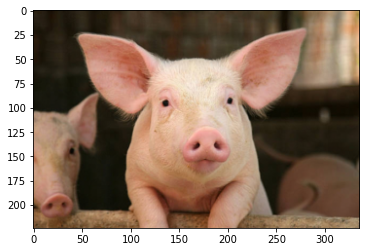

In [27]:
# plot the beginning image

plt.imshow(unnorm(attacked_images)[0].numpy().transpose(1,2,0))
plt.show()